In [ ]:
# Mask R-CNN - Test Crater Model

Code and visualizations to test, debug, and evaluate the Mask R-CNN model.

In [189]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import xml.etree.ElementTree as ET
from imageio import imread, imsave
import sklearn
# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

from samples.crater import crater

%matplotlib inline 
plt.rcParams['figure.figsize'] = [12,12]
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

CRATER_WEIGHTS_PATH = os.path.join("../../logs/2020-06-05/imnet50-all-noaug/crater20200608T1534/mask_rcnn_crater_0149.h5")

In [192]:
config = crater.CraterConfig()
CRATER_DIR = os.path.join(ROOT_DIR, "/home/ali/Data/craters/Mask_rcnn/processed/deLatte-craters/test/test-1024/")

In [39]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.DETECTION_MIN_CONFIDENCE = 0.1
config.DETECTION_MAX_INSTANCES = 200
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        200
DETECTION_MIN_CONFIDENCE       0.1
DETECTION_NMS_THRESHOLD        0.3
EPOCHS                         50
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  1024
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LAYERS                         heads
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn

In [195]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [193]:
# Load validation dataset

dataset = crater.CraterDataset()
dataset.load_crater(CRATER_DIR, "val") # MAKE SURE TEST DATA IS IN "VAL" DIRECTORY. EASIER THAN CHANGING CODE TO HANDLE "test"

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 196
Classes: ['BG', 'crater']


In [196]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

In [197]:
# Set path to crater weights file

# Download file from the Releases page and set its path
# https://github.com/matterport/Mask_RCNN/releases
# weights_path = "/path/to/mask_rcnn_crater.h5"

# Or, load the last model you trained
# weights_path = model.find_last()

# Load weights
print("Loading weights ", CRATER_WEIGHTS_PATH)
model.load_weights(CRATER_WEIGHTS_PATH, by_name=True)

Loading weights  ../../logs/2020-06-05/imnet50-all-noaug/crater20200608T1534/mask_rcnn_crater_0149.h5
Re-starting from epoch 149


### COMPUTE RESULTS: ITERATE THROUGH ENTIRE TEST SET

In [198]:
def results2df(results):
    rois = results[0]['rois']
    class_ids = results[0]['class_ids']
    scores = results[0]['scores']
    Ys = [(roi[2]+roi[0])/2 for roi in rois]
    Xs = [(roi[3]+roi[1])/2 for roi in rois]
    Ds = [(roi[2]-roi[0]+roi[3]-roi[1])/2 for roi in rois]
    df = pd.DataFrame({'x':Xs,'y':Ys,'D':Ds,'score':scores})
    return df

def load_image_GT(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    d = {'x':[],'y':[],'D':[],'confidence':[]}
    df = pd.DataFrame(data = d)
    for child in root:
        if child.tag == 'object':
            for grandchild in child:
                if grandchild.tag == 'bndbox':
                    xmin = float(grandchild[0].text)
                    ymin = float(grandchild[1].text)
                    xmax = float(grandchild[2].text)
                    ymax = float(grandchild[3].text)

                    x = (xmin+xmax)/2
                    y = (ymin+ymax)/2
                    D = xmax-xmin
                    D_ = ymax-ymin
                if grandchild.tag == 'confidence':
                    confidence = float(grandchild.text)
            df_line = pd.DataFrame(data = {
                                    'x':[x],
                                    'y':[y],
                                    'D':[D],
                                    'confidence':[confidence]
                                    })
            df = pd.concat((df,df_line))
    return df

In [199]:
results = {}
GTs = {}
t = time.time()
for id in dataset.image_ids:
    image = dataset.load_image(id)
    results[id] = results2df(model.detect([image], verbose=0)) # Run object detection
    image_path = dataset.image_reference(id)
    xml_path = os.path.join(os.path.dirname(image_path),'annotations.xml') #Get ground-truth
    GTs[id] = load_image_GT(xml_path)
    print(id,end='\r')
print('Time: ', str(time.time()-t)+'s')

    

Time:  170.79143500328064s


### FOR REFERENCE:
 
#### model.detect(image):

    Runs the detection pipeline.
    images: List of images, potentially of different sizes.
    Returns a list of dicts, one dict per image. The dict contains:
    rois: [N, (y1, x1, y2, x2)] detection bounding boxes
    class_ids: [N] int class IDs
    scores: [N] float probability scores for the class IDs
    masks: [H, W, N] instance binary masks

### SANITY CHECK BELOW:  Take one tile and display results

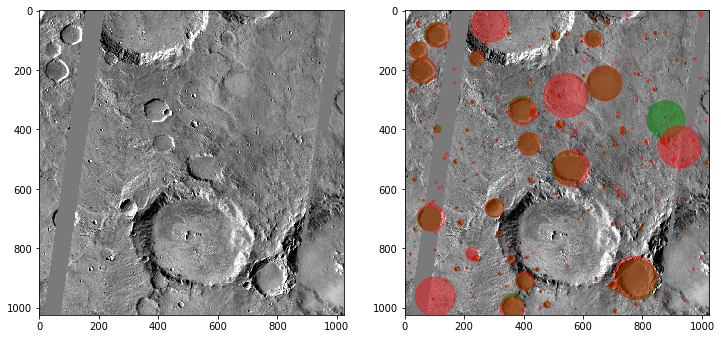

In [200]:
id = 2
threshold = 0.7
preds = results[id]
trues = GTs[id]
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset, config, id, use_mini_mask=False)
fig,ax = plt.subplots(1,2)

dets = preds['score']>threshold

ax[0].imshow(image)
ax[1].imshow(image)
for N,det in enumerate(dets):
    if det==1:
        x = preds['x'][N]*1024/1024
        y = preds['y'][N]*1024/1024
        D = preds['D'][N]*1024/1024
#         ax.plot([x-D/2,x+D/2],[y-D/2,y+D/2],alpha = 0.4,c='r')
#         ax.plot([x+D/2,x-D/2],[y-D/2,y+D/2],alpha = 0.4,c='r')
        ax[1].add_artist(plt.Circle((x,y), D/2, color='g',alpha=0.5))
    
for i,r in trues.iterrows():
    if r['confidence']>2:
        x = r['x']*1024/1024
        y = r['y']*1024/1024
        D = r['D']*1024/1024
#         ax.plot([x-D/2,x+D/2],[y-D/2,y+D/2],alpha = 0.4,c='k')
#         ax.plot([x+D/2,x-D/2],[y-D/2,y+D/2],alpha = 0.4,c='k')    
        ax[1].add_artist(plt.Circle((x,y), D/2, color='r',alpha=0.4))


## Metric definitions
 - **F1_score**: Calculates F1-score at a given threshold and IOU 
 - **prec_rec_curve**: Produces precision-recall curve for IOU of 0.5 and gets mAP
 - **DvsD**: Checks for bias of diameter vs. predicted diameter. Scatter plot with D' = mD + c least-squares fit
 - **compare_CSFD**: Plots cumulative CSFDs for comparison.

In [190]:
def iou(crater1,crater2):
    """
    Calculates amount of overlap as fraction of total union area of two craters
    """
    x1 = crater1['x']
    y1 = crater1['y']
    D1 = crater1['D']
    r1 = D1/2
    
    x2 = crater2['x']
    y2 = crater2['y']
    D2 = crater2['D']   
    r2 = D2/2
    

    if x1==x2 and y1==y2 and r1==r2:
        return 1
    
    d = np.sqrt(np.square((x1-x2))+np.square((y1-y2)))
    
    if d<abs(r1-r2):
        A = np.pi*np.square(min(r1,r2))
    elif d<r1+r2:
        A = np.square(r1)*np.arccos((np.square(d)+np.square(r1)-np.square(r2))/(2*d*r1)) + \
            np.square(r2)*np.arccos((np.square(d)+np.square(r2)-np.square(r1))/(2*d*r2)) - \
            (1/2)*np.sqrt((-d+r1+r2)*(d+r1-r2)*(d-r1+r2)*(d+r1+r2))
    else:
        A = 0
    return A/(np.pi*np.square(r1)+np.pi*np.square(r2)-A)


def all_ious(survey1,survey2):
    ious = np.zeros((len(survey1),len(survey2)))
    for i in range(len(survey1)):
        for j in range(len(survey2)):
            r_i = survey1.iloc[i]
            r_j = survey2.iloc[j]
            ious[i,j] = iou(r_i,r_j)
    return ious

def F1_score(preds,trues,threshold=0.8,IOU=0.5,return_PR=False):

    TP,FP,FN = 0,0,0
    for id,p_i in preds.items():
        t_i = trues[id]
        p_i = p_i.loc[(p_i['score'] > threshold)]
        ious = all_ious(p_i,t_i)>IOU
        if ious.size==0:
            continue
        TP_hits = np.max(ious,axis=1)
        TP+=np.sum(TP_hits)
        FP+=np.sum(TP_hits==0)
        FN+=np.sum(np.max(ious,axis=0)==0)

    prec = TP/(TP+FP)
    rec = TP/(TP+FN)
    F1 = 2*prec*rec/(prec+rec)
    
    if return_PR:
        return prec,rec,F1
    else:
        return F1
    
    

def PR_curve_at_IOU(preds,trues,IOU=0.5):
    pred_probs = []
    binary_trues = []
    for id,p_i in preds.items():
        t_i = trues[id]
        ious = all_ious(p_i,t_i)>IOU
        if ious.size==0:
            continue
        TPs = np.max(ious,axis=1)==1
        FPs = np.max(ious,axis=1)==0
        FNs = np.max(ious,axis=0)==0
        pred_probs += p_i['score'][TPs].tolist()+p_i['score'][FPs].tolist()+[0]*np.sum(FNs)
        binary_trues += [1]*np.sum(TPs)+[0]*np.sum(FPs)+[1]*np.sum(FNs)

    return sklearn.metrics.precision_recall_curve(binary_trues,pred_probs)


def AP_at_IOU(preds,trues,IOU=0.5):
    #TESTS NEEDED
    pred_probs = []
    binary_trues = []
    for id,p_i in preds.items():
        t_i = trues[id]
        ious = all_ious(p_i,t_i)>IOU
        if ious.size==0:
            continue
        TPs = np.max(ious,axis=1)==1
        FPs = np.max(ious,axis=1)==0
        FNs = np.max(ious,axis=0)==0
        pred_probs += p_i['score'][TPs].tolist()+p_i['score'][FPs].tolist()+[0]*np.sum(FNs)
        binary_trues += [1]*np.sum(TPs)+[0]*np.sum(FPs)+[1]*np.sum(FNs)

    return sklearn.metrics.average_precision_score(binary_trues,pred_probs)

def DvsD(preds,trues,IOU=0.5):
    pred_D = []
    true_D = []
    for id,p_i in preds.items():
        t_i = trues[id]
        ious = all_ious(p_i,t_i)
        if ious.size==0:
            continue
        found_craters = np.max(ious,axis=0)>IOU
        found_craters_predIDs = np.argmax(ious[:,found_craters],axis=0)
        true_D += t_i['D'][found_craters].tolist()
        pred_D += p_i['D'][found_craters_predIDs].tolist()
    return true_D,pred_D


def CSFD(dfs,threshold=None):
    resolution = 6*800/1024
    diams = []
    for id,df in dfs.items():
        if threshold is None:
            diams += [i*resolution for i in df['D'].tolist()]
        else:
            diams +=  [i*resolution for i in df['D'][df['score']>threshold].tolist()]
    bin_edges = np.power(10,np.linspace(np.log10(20),np.log10(1200),30))
    dys,_ = np.histogram(diams,bin_edges)
    ys = np.cumsum(dys[::-1])[::-1]/(5*12**2) #divided by area in km^2
    smooth_ys = np.array([np.mean(ys[max(0,i-1):min(len(ys),i+2)]) for i in range(len(ys))])
    smooth_dys = np.array([np.mean(dys[max(0,i-3):min(len(dys),i+4)]) for i in range(len(dys))])
    return bin_edges, smooth_ys, smooth_dys

def compare_CSFDs(preds,trues,threshold=0.5):
    pred_bins, pred_ys, pred_dys = CSFD(preds,threshold=threshold)
    true_bins, true_ys, true_dys = CSFD(trues)
    fig,ax = plt.subplots(1,2)
    ax[0].plot(pred_bins[:-1]+np.diff(pred_bins)/2,pred_dys,alpha=0.8,c='b',marker='v',linewidth=0.8,linestyle='-',fillstyle='none',label='PREDICTED')
    ax[0].plot(true_bins[:-1]+np.diff(true_bins)/2,true_dys,alpha=0.8,c='k',marker='+',linewidth=0.8,linestyle='-',fillstyle='none',label='LABELS')
    ax[0].set_xscale('log')
    ax[0].set_yscale('log')
    ax[0].grid(which='minor')
    ax[0].legend()
    ax[0].set_ylabel('CSFD')
    ax[0].set_xlabel('Diameter')
    ax[1].plot(pred_bins[:-1]+np.diff(pred_bins)/2,pred_ys,alpha=0.8,c='b',marker='v',linewidth=0.8,linestyle='-',fillstyle='none',label='PREDICTED')
    ax[1].plot(true_bins[:-1]+np.diff(true_bins)/2,true_ys,alpha=0.8,c='k',marker='+',linewidth=0.8,linestyle='-',fillstyle='none',label='LABELS')
    ax[1].set_xscale('log')
    ax[1].set_yscale('log')
    ax[1].grid(which='minor')
    ax[1].legend()
    ax[1].set_ylabel('Cumulative CSFD')
    ax[1].set_xlabel('Diameter')
    plt.show()
    return None

0.9729525261469809 -1.018717412921199


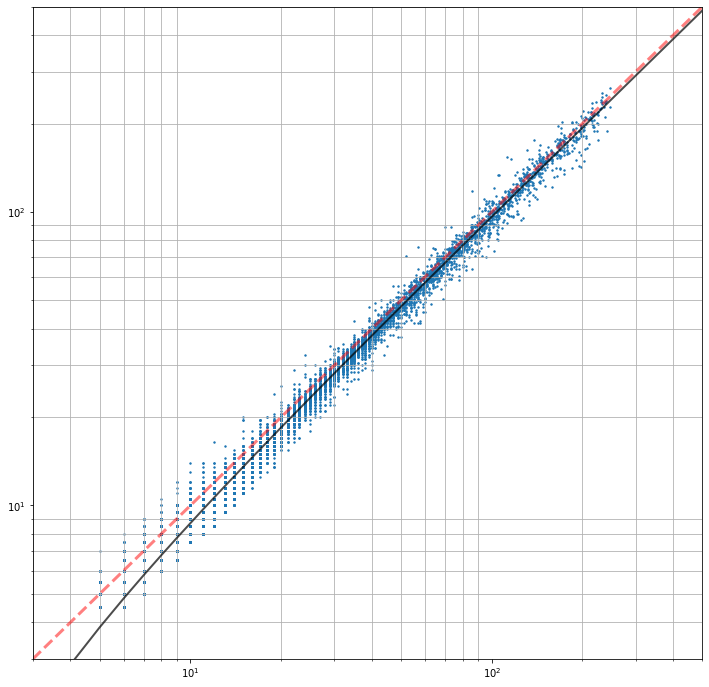

In [207]:

# t,p=DvsD(results,GTs)
# m,c = np.polyfit(t, p, 1)
print(m,c)
fig,ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([3,500])
ax.set_ylim([3,500])
ax.grid(which='minor')
ax.plot([3,500],[3,500],linewidth=3,linestyle='--',c='r',alpha=0.5)
xs = [i for i in range(3,501)]
ax.plot(xs,[m*x+c for x in xs],linewidth=2,linestyle='-',c='k',alpha=0.7)
ax.scatter(t,p,s=2)
plt.show()


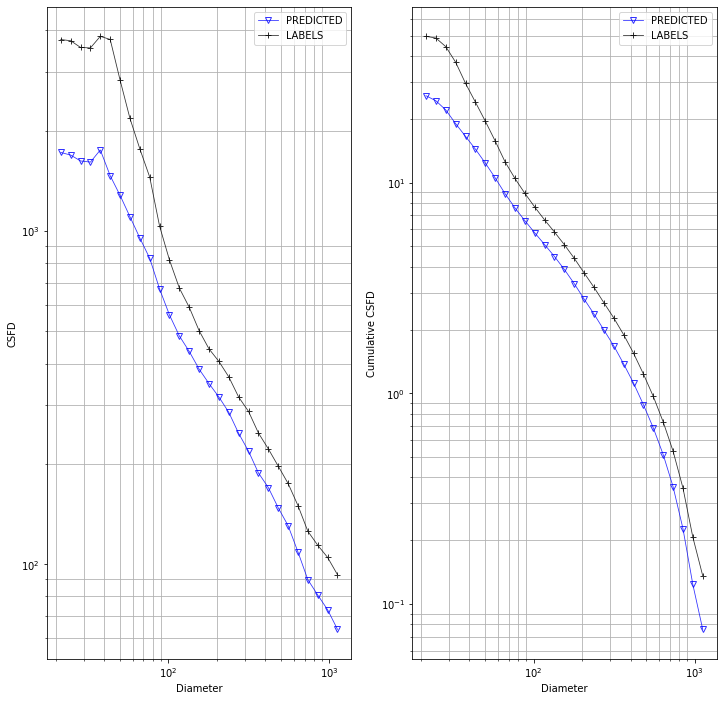

In [208]:
compare_CSFDs(results,GTs,threshold=0.55)

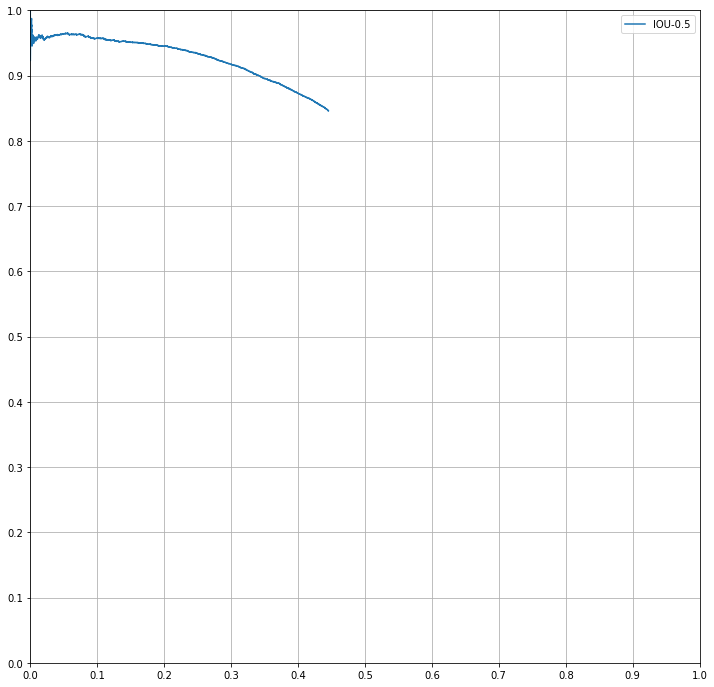

In [209]:
fig,ax = plt.subplots()
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_xticks([0.1*i for i in range(11)])
ax.set_yticks([0.1*i for i in range(11)])
ax.grid(True)
for inter in [0.5]:
    precision,recall,_=ranked_detections_at_IOU(results,GTs,IOU=inter)
    ax.plot(recall[1:],precision[1:],label='IOU-{}'.format(inter))
ax.legend()
plt.show()


In [117]:
for inter in [0.5,0.6,0.7,0.8,0.9,0.95,0.99]:
    print(inter,AP_at_IOU(results,GTs,IOU=inter))

0.5 0.8134829088604456
0.6 0.7504463123954803
0.7 0.6252349014181622
0.8 0.5418359704943642
0.9 0.5206838274177874
0.95 0.5207970650269185
0.99 0.5217686904032055



512
------
0.4 0.39863130881094955
0.75 0.527431421446384
0.8 0.5443466486120514
0.85 0.575075075075075
0.9 0.5813377374071015
0.99 0.37837837837837834


800
-----
0.4 0.5310848225522276
0.75 0.5969868173258004
0.8 0.6001313197636244
0.85 0.5951557093425606
0.9 0.5759704251386322
0.99 0.37168993740972556


1024
----


## BONUS: 

### Detection over sample from murray labs CTX mosaic, from Isidis Planitia!


In [110]:
murray_results = []
murray_dir = '/home/ali/Data/craters/Murray/Murray-Lab_CTX-Mosaic_beta01_E084_N08_data/crops/'
ims = [imread(os.path.join(murray_dir,str(i)+'.png')) for i in range(25)]
ims = [np.stack([im,im,im],axis=2) for im in ims]
for im in ims:
    murray_results.append(results2df(model.detect([im], verbose=0))) # Run object detection
    

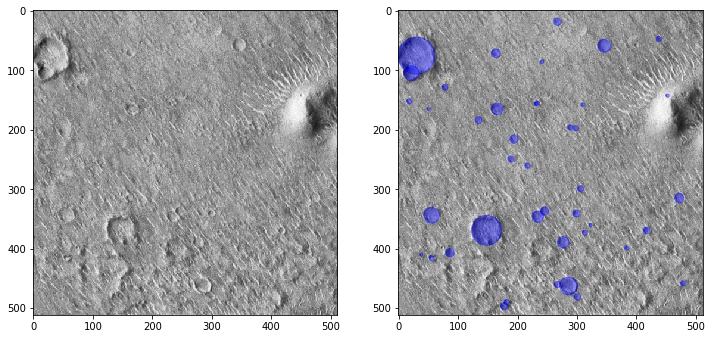

In [210]:
id = 24
threshold = 0.7
preds = murray_results[id]
image = ims[id]
fig,ax = plt.subplots(1,2)

dets = preds['score']>threshold

ax[0].imshow(image)
ax[1].imshow(image)
for N,det in enumerate(dets):
    if det==1:
        x = preds['x'][N]
        y = preds['y'][N]
        D = preds['D'][N]
        score = preds['score'][N]
        ax[1].add_artist(plt.Circle((x,y), D/2, color='b',alpha=0.4))

[32, 62, 25, 36, 70, 52, 8, 4, 4, 53, 102, 115, 8, 99, 33, 10, 26, 1, 15, 16, 116, 72, 41, 80, 8, 71, 139, 0, 116, 113, 28, 44, 10, 14, 38, 7, 79, 1, 52, 41, 3, 10, 67, 65, 8, 2, 4, 87, 95, 9, 56, 65, 19, 12, 109, 45, 6, 6, 10, 136, 51, 52, 43, 75, 104, 87, 3, 6, 57, 21, 106, 10, 91, 17, 15, 2, 32, 10, 49, 11, 12, 66, 30, 8, 10, 2, 14, 42, 7, 3, 49, 4, 16, 25, 10, 22]
3817 0 139
